<a href="https://colab.research.google.com/github/casangi/radio_telescope_delay_model/blob/main/example_notebooks/Radio_Telescope_Delay_Model_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Radio Telescope Delay Model

This notebook compares the uvw coordinates calculated by Astropy, CASA, CALC11, and those that are present in a measurement set.

## Install Packages

In [ ]:
import os
os.system("apt-get install libgfortran3") #Needed for casatools
os.system("pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools==6.0.0.27")
os.system("pip install zarr")
os.system("pip install radio_telescope_delay_model")

0

## Import Packages and Download IERS Table

In [ ]:
import os
import xarray as xr
from astropy.time import Time
import numpy as np
import astropy.coordinates as coord
import astropy.time
import astropy.units as u
import matplotlib.pyplot as plt

# Can do this to get updated IERS B values into astropy
from astropy.utils import iers
from astropy.utils import data
from astropy.time import Time
iers_b = iers.IERS_B.open(data.download_file(iers.IERS_B_URL, cache=True))
iers_a = iers.IERS_A.open(data.download_file(iers.IERS_A_URL, cache=True))
iers_auto = iers.IERS_Auto.open()
import casatools
from calc11 import almacalc

## Download Dataset

The measurement set data has been converted to vis.zarr (sis14_twhya_single_field_1chan.vis.zarr) and uploaded to google drive. For more information on the vis.zarr format go [here](https://cngi-prototype.readthedocs.io/en/latest/design.html#Zarr-Data-Format).


In [ ]:
#https://drive.google.com/file/d/1ddW3kBTFehWVfIIUz6-Poa7iQw_IauJe/view?usp=sharing sis14_twhya_single_field_1chan.vis.zarr
#https://drive.google.com/file/d/1fcyrHpLkrzgRtDe7nAZvV3N-qFKvwcn7/view?usp=sharing DE421_little_Endian
for id in ['1ddW3kBTFehWVfIIUz6-Poa7iQw_IauJe','1fcyrHpLkrzgRtDe7nAZvV3N-qFKvwcn7']:
    os.system('curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=%s"' % id)
    os.system('curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk \'/download/ {print $NF}\' ./cookie`&id=%s" -o vis.zarr.zip' % id)
    os.system('unzip vis.zarr.zip')
print('complete')

xr.set_options(display_style="html")

#Load ms data
vis_dataset = xr.open_zarr('sis14_twhya_single_field_1chan.vis.zarr/0')
global_dataset = xr.open_zarr('sis14_twhya_single_field_1chan.vis.zarr/global')

vis_dataset

complete


<xarray.Dataset>
Dimensions:        (baseline: 300, chan: 1, pair: 2, pol: 2, receptor: 2, spw: 1, time: 270, uvw_index: 3)
Coordinates:
    antennas       (baseline, pair) int32 dask.array<chunksize=(300, 2), meta=np.ndarray>
  * baseline       (baseline) int64 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  * chan           (chan) float64 3.726e+11
    chan_width     (chan) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    corr_product   (receptor, pol) int32 dask.array<chunksize=(2, 1), meta=np.ndarray>
    effective_bw   (chan) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    field          (time) <U6 dask.array<chunksize=(100,), meta=np.ndarray>
    field_id       (time) int32 dask.array<chunksize=(100,), meta=np.ndarray>
    interval       (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    observation    (time) <U22 dask.array<chunksize=(100,), meta=np.ndarray>
  * pol            (pol) int32 9 12
    processor      (time) <U14 dask.array<chunksize=(100,), meta=np.ndarray>
    resolution     (chan) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    scan           (time) int32 dask.array<chunksize=(100,), meta=np.ndarray>
  * spw            (spw) int32 0
    state          (time) <U82 dask.array<chunksize=(100,), meta=np.ndarray>
  * time           (time) datetime64[ns] 2012-11-19T07:56:26.544000626 ... 2012-11-19T09:07:28.607999802
  * uvw_index      (uvw_index) <U2 'uu' 'vv' 'ww'
Dimensions without coordinates: pair, receptor
Data variables:
    ARRAY_ID       (time, baseline) int32 dask.array<chunksize=(100, 300), meta=np.ndarray>
    DATA           (time, baseline, chan, pol) complex128 dask.array<chunksize=(100, 300, 1, 1), meta=np.ndarray>
    EXPOSURE       (time, baseline) float64 dask.array<chunksize=(100, 300), meta=np.ndarray>
    FEED1          (time, baseline) int32 dask.array<chunksize=(100, 300), meta=np.ndarray>
    FEED2          (time, baseline) int32 dask.array<chunksize=(100, 300), meta=np.ndarray>
    FLAG           (time, baseline, chan, pol) bool dask.array<chunksize=(100, 300, 1, 1), meta=np.ndarray>
    FLAG_ROW       (time, baseline) bool dask.array<chunksize=(100, 300), meta=np.ndarray>
    SIGMA          (time, baseline, pol) float64 dask.array<chunksize=(100, 300, 1), meta=np.ndarray>
    TIME_CENTROID  (time, baseline) float64 dask.array<chunksize=(100, 300), meta=np.ndarray>
    UVW            (time, baseline, uvw_index) float64 dask.array<chunksize=(100, 300, 3), meta=np.ndarray>
    WEIGHT         (time, baseline, pol) float64 dask.array<chunksize=(100, 300, 1), meta=np.ndarray>
Attributes:
    auto_correlations:  0
    bbc_no:             2
    ddi:                0
    freq_group:         0
    freq_group_name:    
    if_conv_chain:      0
    meas_freq_ref:      5
    name:               ALMA_RB_07#BB_2#SW-01#FULL_RES
    net_sideband:       2
    num_chan:           1
    ref_frequency:      372569707519.7312
    total_bandwidth:    610351.5625

## Astropy Function

In [ ]:
def calc_uvw_astropy(ant_pos, mjd, site, pointing_direction):
    """
    Parameters
    ----------
    ant_pos : numpy.array (n_antx3), Geocentric ITRF, m
    mjd : numpy.array (n_time), Modified Julian Day, UTC
    site : str
        Site name
    pointing_direction : string
        Define the UVW frame relative to a certain point on the sky.
    Returns
    -------
    ant_uvw
    """

    # VLA B-config positions, ITRF, m
    ant_pos = ant_pos* u.m

    # Time of observation:
    t = astropy.time.Time(mjd, format='mjd', scale='utc')

    # Format antenna positions and VLA center as EarthLocation.
    antpos_ap = coord.EarthLocation(x=ant_pos[:,0], y=ant_pos[:,1], z=ant_pos[:,2])
    tel_site = coord.EarthLocation.of_site(site)

    # Convert antenna pos terrestrial to celestial.  For astropy use
    # get_gcrs_posvel(t)[0] rather than get_gcrs(t) because if a velocity
    # is attached to the coordinate astropy will not allow us to do additional
    # transformations with it (https://github.com/astropy/astropy/issues/6280)
    tel_site_p, tel_site_v = tel_site.get_gcrs_posvel(t)
    antpos_c_ap = coord.GCRS(antpos_ap.get_gcrs_posvel(t)[0],
            obstime=t, obsgeoloc=tel_site_p, obsgeovel=tel_site_v)

    pointing_direction = coord.SkyCoord(pointing_direction[:,0]*u.rad, pointing_direction[:,1]*u.rad, frame='icrs')
    
    #frame_uvw = pointing_direction.skyoffset_frame() # ICRS
    frame_uvw = pointing_direction.transform_to(antpos_c_ap).skyoffset_frame() # GCRS

    # Rotate antenna positions into UVW frame.
    antpos_uvw_ap = antpos_c_ap.transform_to(frame_uvw).cartesian
    
    ant_uvw = np.array([antpos_uvw_ap.y,antpos_uvw_ap.z,antpos_uvw_ap.x]).T
  
    return ant_uvw
    

## CASA Function

In [ ]:
def calc_uvw_casa(ant_pos, mjd, site, pointing_direction):
    """
    Parameters
    ----------
    ant_pos : numpy.array (n_antx3), Geocentric ITRF, m
    mjd : numpy.array (n_time), Modified Julian Day, UTC
    site : str
        Site name
    pointing_direction : string
        Define the UVW frame relative to a certain point on the sky.
    Returns
    -------
    ant_uvw
    """
    
    try:
        import casatools
    except ImportError:
        print('casatools not installed')
        return

    def casa_to_astropy(c):
        """Convert CASA spherical coords to astropy CartesianRepresentation"""
        sph = coord.SphericalRepresentation(
                lon=c['m0']['value']*u.Unit(c['m0']['unit']),
                lat=c['m1']['value']*u.Unit(c['m1']['unit']),
                distance=c['m2']['value']*u.Unit(c['m2']['unit']))
        return sph.represent_as(coord.CartesianRepresentation)

    # The necessary interfaces:
    me = casatools.measures()
    qa = casatools.quanta()
    qq = qa.quantity

    # Init CASA frame info:
    me.doframe(me.observatory(site))
    me.doframe(me.epoch('UTC',qq(mjd,'d')))
    pointing_direction = coord.SkyCoord(pointing_direction[:,0]*u.rad, pointing_direction[:,1]*u.rad, frame='icrs')
    me.doframe(me.direction('J2000',
        qq(pointing_direction.ra.to(u.rad).value, 'rad'),
        qq(pointing_direction.dec.to(u.rad).value, 'rad')))

    # Format antenna positions for CASA:
    antpos_casa = me.position('ITRF',
            qq(ant_pos[:,0],'m'),
            qq(ant_pos[:,1],'m'),
            qq(ant_pos[:,2],'m'))

    # Converts from ITRF to "J2000":
    antpos_c_casa = me.asbaseline(antpos_casa)

    # Rotate into UVW frame
    antpos_uvw_casa = me.touvw(antpos_c_casa)[0]

    ant_uvw = casa_to_astropy(antpos_uvw_casa)
    
    return ant_uvw.xyz.value.T

## CALC Function

In [ ]:
def find_nearest(array, values):
    indices = np.abs(np.subtract.outer(array, values)).argmin(0)
    return indices
     
def calc_uvw_CALC(ant_pos, mjd, pointing_direction,delta = 0.00001):
    """
    Parameters
    ----------
    ant_pos : numpy.array (n_antx3), Geocentric ITRF, m
    mjd : numpy.array (n_time), Modified Julian Day, UTC
    pointing_direction : string
        Define the UVW frame relative to a certain point on the sky.
    Returns
    -------
    ant_uvw
    """
    
    from calc11 import almacalc
    ref_antenna  = 0 #Choosing the first antenna as the reference
    n_times = len(mjd)

    ########################################################################################################
    #Geocentric (ITRF) position of each antenna.
    #ant_pos #n_ant x 3
    ant_x = np.ascontiguousarray(ant_pos[:,0])
    ant_y = np.ascontiguousarray(ant_pos[:,1])
    ant_z = np.ascontiguousarray(ant_pos[:,2])
    n_ant = ant_x.shape[0]
    #Geocentric position of the array reference point (ITRF).
    ref_x = ant_x[ref_antenna]
    ref_y = ant_y[ref_antenna]
    ref_z = ant_z[ref_antenna]
    ########################################################################################################
    # Temperature (deg. C), Pressure (hPa/mbar), and humidity (0-1) at each antenna
    #      REAL*8 temp(nant), pressure(nant), humidity(nant)
    # Only effects dry and wet delay
    temp = np.array([-1.68070068]*n_ant)  #To deg C, n_ant
    pressure = np.array([555.25872803]*n_ant) #Pressure (hPa/mbar), n_ant
    humidity = np.array([0.054894]*n_ant) #humidity (0-1), n_ant

    ########################################################################################################
    #pointing_direction radians, n_time x 2
    ra = np.ascontiguousarray(pointing_direction[:,0])
    dec = np.ascontiguousarray(pointing_direction[:,1])

    ssobj = np.zeros(n_times, dtype=bool) #True if the source is a solar system object.
    #Earth orientation parameters at each time (arc-sec, arc-sec, sec)
    iers_b = iers.IERS_B.open()
    dx_dy = np.ascontiguousarray(np.array(iers_b.pm_xy(time_obj))) #2 x n_time
    dx = np.ascontiguousarray(np.array(dx_dy[0,:]))
    dy = np.ascontiguousarray(np.array(dx_dy[1,:]))
    dut  = np.ascontiguousarray(np.array(iers_b.ut1_utc(time_obj)))

    leapsec = 35
    axisoff = np.zeros(n_ant)
    
    sourcename = np.array(['P'] * n_times) # source names, for future use with solar system objects
    jpx_de421 = 'DE421_little_Endian' #Path name of the JPL ephemeris
    
    #Calculate uvw using same math as DiFX (The software is availble at https://www.atnf.csiro.au/vlbi/dokuwiki/doku.php/difx/installation see Applications/calcif2/src/difxcalc.c::callCalc for math)
    geodelay, drydelay, wetdelay = almacalc(ref_x, ref_y, ref_z, ant_x, ant_y,ant_z, temp, pressure, humidity, mjd, ra, dec, ssobj,dx, dy, dut, leapsec, axisoff,sourcename, jpx_de421)
    ra_x = ra - delta/np.cos(dec)
    geodelay_x, drydelay_x, wetdelay_x = almacalc(ref_x, ref_y, ref_z, ant_x, ant_y,ant_z, temp, pressure, humidity, mjd, ra_x, dec, ssobj,dx, dy, dut, leapsec, axisoff,sourcename, jpx_de421)
    dec_y = dec + delta
    geodelay_y, drydelay_y, wetdelay_y = almacalc(ref_x, ref_y, ref_z, ant_x, ant_y,ant_z, temp, pressure, humidity, mjd, ra, dec_y, ssobj,dx, dy, dut, leapsec, axisoff,sourcename, jpx_de421)

    c = 299792458
    
    u = (c/delta)*(geodelay-geodelay_x)[:,0]
    v = (c/delta)*(geodelay_y-geodelay)[:,0]
    w = (c*geodelay)[:,0]
    
    '''
    total_delay = geodelay + drydelay + wetdelay
    total_delay_x = geodelay_x + drydelay_x + wetdelay_x
    total_delay_y = geodelay_y + drydelay_y + wetdelay_y

    u = (c/delta)*(total_delay-total_delay_x)[:,0]
    v = (c/delta)*(total_delay_y-total_delay)[:,0]
    w = (c*total_delay)[:,0]
    '''
    
    uvw = np.array([u,v,w]).T
    return uvw

## Run and Compare Functions

Text(0.5, 1.0, 'w Coord')

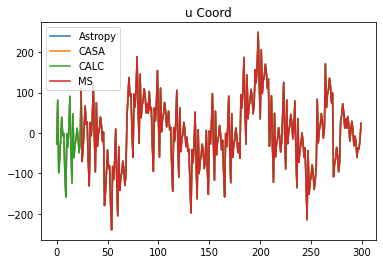

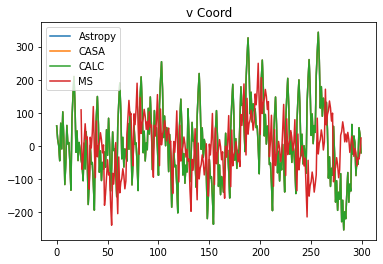

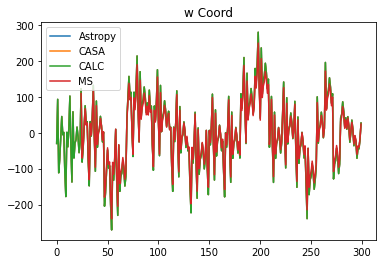

In [ ]:
#Custom User Pointing. If True the comparison with the measurement set (vis.zarr) is ignored.
use_user_pointing = False
user_pointing_direction = [[2.8879233,  np.pi/2]] #ra dec in radians

ant_pos = global_dataset.ANT_POSITION.data.compute() #n_ant x 3
site = 'alma'
time_indx = 0 #The uvw coordinates are only calculated for a single time step.
fields = vis_dataset.time.field_id[time_indx:time_indx+1].data.compute()
pointing_direction = global_dataset.FIELD_PHASE_DIR[fields,:,0].data.compute() 

if use_user_pointing:
    pointing_direction = np.array(user_pointing_direction)

time_obj = Time(vis_dataset.time.data[time_indx], scale='utc')
mjd = np.ascontiguousarray(time_obj.mjd)

#Antenna uvw 
uvw_astropy = calc_uvw_astropy(ant_pos, mjd, site, pointing_direction)
uvw_casa = calc_uvw_casa(ant_pos, mjd, site, pointing_direction)

#CALC11 wrapped code needs at least two time steps otherwise it returns nan 
#(the calculations are independent, the issue has to do with singleton dimensions). 
#The second time step is ignored in calc_uvw_CALC.
fields = vis_dataset.time.field_id[time_indx:time_indx+2].data.compute()
pointing_direction = global_dataset.FIELD_PHASE_DIR[fields,:,0].data.compute() 
time_obj = Time(vis_dataset.time.data[time_indx:time_indx+2], scale='utc')
mjd = np.ascontiguousarray(time_obj.mjd)
if use_user_pointing:
    pointing_direction = np.array([user_pointing_direction[0]]*len(mjd))
    
uvw_CALC = calc_uvw_CALC(ant_pos, mjd, pointing_direction,delta = 0.00001)

#Baseline uvw
uvw_baseline_astropy = uvw_astropy[vis_dataset.antennas[:,0]] - uvw_astropy[vis_dataset.antennas[:,1]]
uvw_baseline_casa = uvw_casa[vis_dataset.antennas[:,0]] - uvw_casa[vis_dataset.antennas[:,1]]
uvw_baseline_CALC = - uvw_CALC[vis_dataset.antennas[:,0]] + uvw_CALC[vis_dataset.antennas[:,1]]

dif1 = (vis_dataset.UVW[time_indx,:,:].values - uvw_baseline_astropy)
dif2 = (vis_dataset.UVW[time_indx,:,:].values - uvw_baseline_casa)
dif3 = (vis_dataset.UVW[time_indx,:,:].values - uvw_baseline_CALC)  
dif4 = (uvw_baseline_astropy - uvw_baseline_casa)
dif5 = (uvw_baseline_casa - uvw_baseline_CALC)
dif6 = (uvw_baseline_astropy - uvw_baseline_CALC)

dif1_per = 100*(vis_dataset.UVW[time_indx,:,:].values - uvw_baseline_astropy)/vis_dataset.UVW[time_indx,:,:].values  
dif2_per = 100*(vis_dataset.UVW[time_indx,:,:].values - uvw_baseline_casa)/vis_dataset.UVW[time_indx,:,:]
dif3_per = 100*(vis_dataset.UVW[time_indx,:,:].values - uvw_baseline_CALC)/vis_dataset.UVW[time_indx,:,:]  
dif4_per = 100*(uvw_baseline_astropy - uvw_baseline_casa)/uvw_baseline_casa
dif5_per = 100*(uvw_baseline_casa - uvw_baseline_CALC)/uvw_baseline_casa   
dif6_per = 100*(uvw_baseline_astropy - uvw_baseline_CALC)/uvw_baseline_casa

plt.figure()
plt.plot(uvw_baseline_astropy[:,0])
plt.plot(uvw_baseline_casa[:,0])
plt.plot(uvw_baseline_CALC[:,0])
if use_user_pointing:
    plt.legend(['Astropy', 'CASA', 'CALC'])
else: 
    plt.plot(vis_dataset.UVW[time_indx,:,0].values)
    plt.legend(['Astropy', 'CASA', 'CALC', 'MS'])
plt.title('u Coord')

plt.figure()
plt.plot(uvw_baseline_astropy[:,1])
plt.plot(uvw_baseline_casa[:,1])
plt.plot(uvw_baseline_CALC[:,1])
if use_user_pointing:
    plt.legend(['Astropy', 'CASA', 'CALC'])
else: 
    plt.plot(vis_dataset.UVW[time_indx,:,1].values)
    plt.legend(['Astropy', 'CASA', 'CALC', 'MS'])
plt.title('v Coord')


plt.figure()
plt.plot(uvw_baseline_astropy[:,2])
plt.plot(uvw_baseline_casa[:,2])
plt.plot(uvw_baseline_CALC[:,2])
if use_user_pointing:
    plt.legend(['Astropy', 'CASA', 'CALC'])
else: 
    plt.plot(vis_dataset.UVW[time_indx,:,2].values)
    plt.legend(['Astropy', 'CASA', 'CALC', 'MS'])
plt.title('w Coord')



Text(0.5, 1.0, 'Astropy vs CALC')

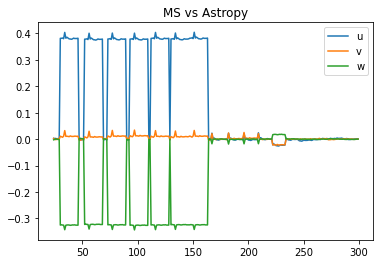

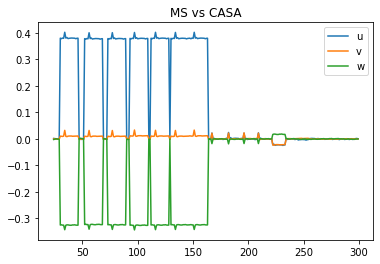

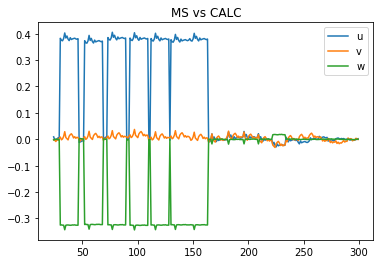

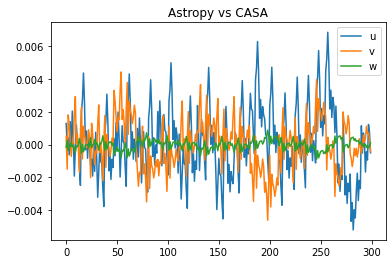

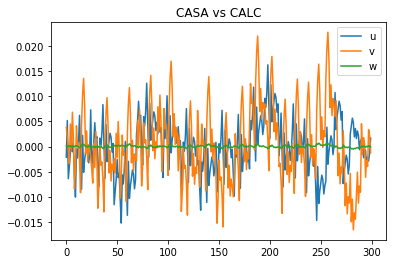

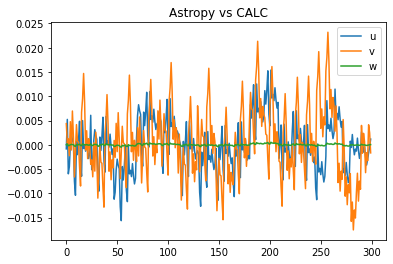

In [ ]:
if not use_user_pointing:
    plt.figure()
    plt.plot(dif1)
    plt.legend(['u', 'v', 'w'])
    plt.title('MS vs Astropy')

    plt.figure()
    plt.plot(dif2)
    plt.legend(['u', 'v', 'w'])
    plt.title('MS vs CASA')

    plt.figure()
    plt.plot(dif3)
    plt.legend(['u', 'v', 'w'])
    plt.title('MS vs CALC')

plt.figure()
plt.plot(dif4)
plt.legend(['u', 'v', 'w'])
plt.title('Astropy vs CASA')

plt.figure()
plt.plot(dif5)
plt.legend(['u', 'v', 'w'])
plt.title('CASA vs CALC')

plt.figure()
plt.plot(dif6)
plt.legend(['u', 'v', 'w'])
plt.title('Astropy vs CALC')


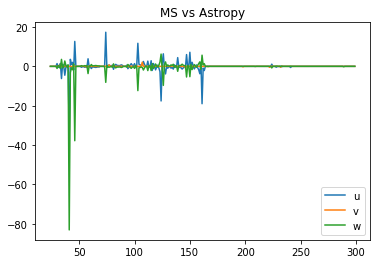

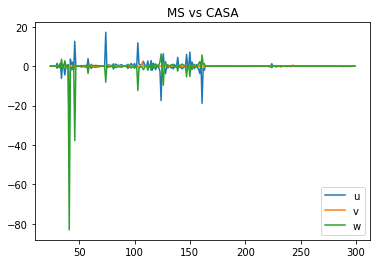

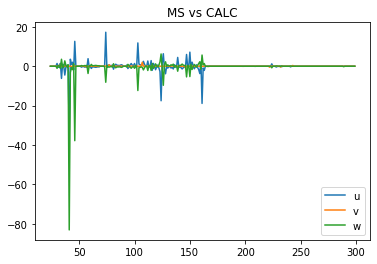

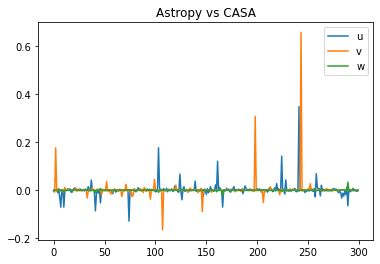

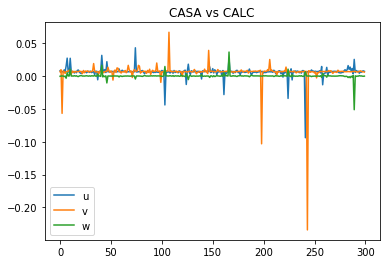

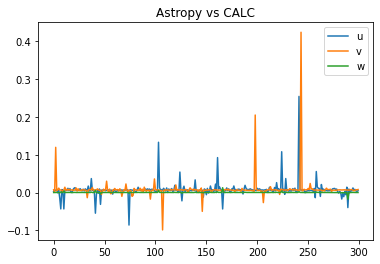

In [ ]:
if not use_user_pointing:
    plt.figure()
    plt.plot(dif1_per)
    plt.legend(['u', 'v', 'w'])
    plt.title('MS vs Astropy')

    plt.figure()
    plt.plot(dif2_per)
    plt.legend(['u', 'v', 'w'])
    plt.title('MS vs CASA')

    plt.figure()
    plt.plot(dif3_per)
    plt.legend(['u', 'v', 'w'])
    plt.title('MS vs CALC')

plt.figure()
plt.plot(dif4_per)
plt.legend(['u', 'v', 'w'])
plt.title('Astropy vs CASA')

plt.figure()
plt.plot(dif5_per)
plt.legend(['u', 'v', 'w'])
plt.title('CASA vs CALC')

plt.figure()
plt.plot(dif6_per)
plt.legend(['u', 'v', 'w'])
plt.title('Astropy vs CALC')


plt.show()